# The Puerto Rice GeoHealth Notebook

This notebook describes how to:
1. load a Digital Elevation Model (DEM) or Puerto Rico into a *landlab* grid,
1. plot the elevations as an image,
1. dilineate the DEM into separate watersheds,
1. load location data from a file,
1. plot locations and watersheds.

## Read a DEM of Puerto Rico

First, import what we'll need.

In [1]:
import numpy as np
import landlab
import matplotlib.pyplot as plt
%matplotlib inline

To read a DEM from an ESRI ASCII file into a landlab grid, use the `read_esri_ascii` landlab function. The following lines reads elevations from a DEM, creates a landlab `RasterModelGrid` and creates a field, labeled *"topographic__elevation"*, that contains elevations. The elevations are defined at the *nodes* of the grid.

In [2]:
%%time
# slow step

grid, z = landlab.io.read_esri_ascii("data/pr_demfil_90.asc", name="topographic__elevation")

CPU times: user 49.3 s, sys: 2.86 s, total: 52.2 s
Wall time: 52.2 s


For our analysis, we will want to only examine the parts of the grid that are on land. To do this, we mask out all of the elevations that are below sea level by setting them to -999.

In [3]:
ocean = grid.at_node["topographic__elevation"] < 0.
grid.at_node["topographic__elevation"][ocean] = -999.

grid.set_nodata_nodes_to_closed(z, nodata_value=-999.)

Use the `imshow_grid` function to plot the elevations.

CPU times: user 605 ms, sys: 158 ms, total: 763 ms
Wall time: 760 ms


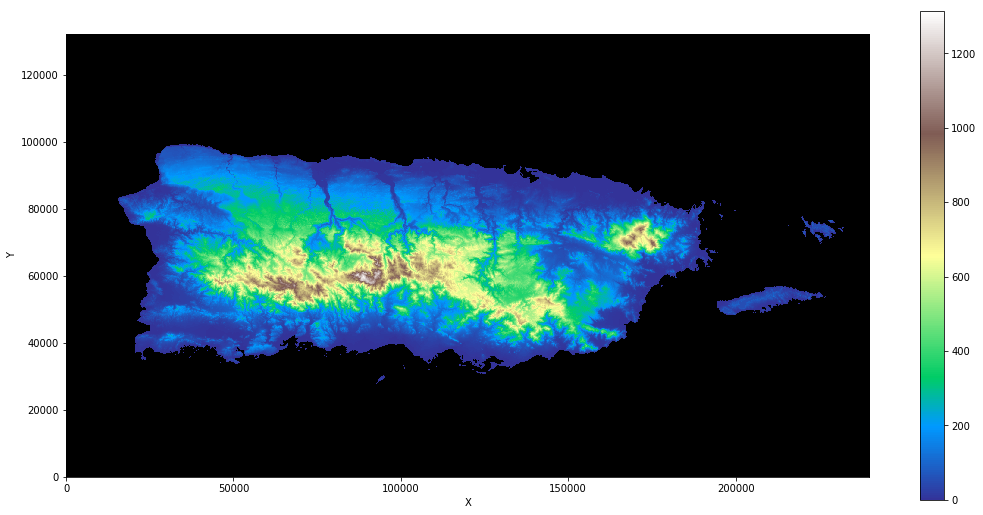

In [4]:
%%time
# somewhat slow step

fig, ax = plt.subplots(figsize=(18, 9))
landlab.plot.imshow_grid(grid, "topographic__elevation", cmap="terrain")

# Find watersheds

In this next section, we use landlab to delineate seperate watersheds based on the DEM we just loaded.

In [5]:
from landlab.components import FlowAccumulator
from landlab.utils import get_watershed_masks_with_area_threshold

Before doing the actual delineation, we must route flow over the landscape. This is done with the landlab `FlowAccumulator` component.

*NOTE: This step will probably takes a few minutes to complete*

In [6]:
%%time 
# somewhat slow step

flow_accumulator = FlowAccumulator(grid, flow_director='D8')
flow_accumulator.run_one_step()

CPU times: user 28.6 s, sys: 1.76 s, total: 30.3 s
Wall time: 30.3 s


Once the `FlowAccumulator` runs, `get_watershed_masks_with_area_threshold` can be used to define the many watersheds. The resulting array, which is the same size as the DEM, is an array of watershed IDs.

In [7]:
%%time
# super slow step

watersheds = get_watershed_masks_with_area_threshold(grid, 8e4)

CPU times: user 2.41 s, sys: 817 µs, total: 2.41 s
Wall time: 2.41 s


The following cell defines a helper function that creates a useful colormap that can be used when we create a plot of the watersheds.

In [8]:
def rand_cmap(n_values, select=None, alpha=None):
    #import matplotlib.pyplot as plt
    #import numpy as np
    if alpha is None:
        alpha = 0.
    low, high = 0.6, 0.95
    if select is None:
        colors = np.random.uniform(low=low, high=high, size=n_values * 3).reshape((-1, 3))
    else:
        colors = np.zeros(n_values * 3).reshape((-1, 3))
        colors[select] = np.random.uniform(low=low, high=high, size=len(select) * 3).reshape((-1, 3))

    cmap = plt.cm.colors.ListedColormap(colors)
    cmap.set_under('white')

    cmap._init()
    if select is None:
        cmap._lut[:, 3] = alpha
    else:
        cmap._lut[:, 3] = 0.2
        cmap._lut[select, 3] = 1.
    
    return cmap

We can now look at the many watersheds that were delineated. There a so many small watersheds that you may need to zoom in to see individual watersheds.

CPU times: user 1.93 s, sys: 709 ms, total: 2.64 s
Wall time: 2.63 s


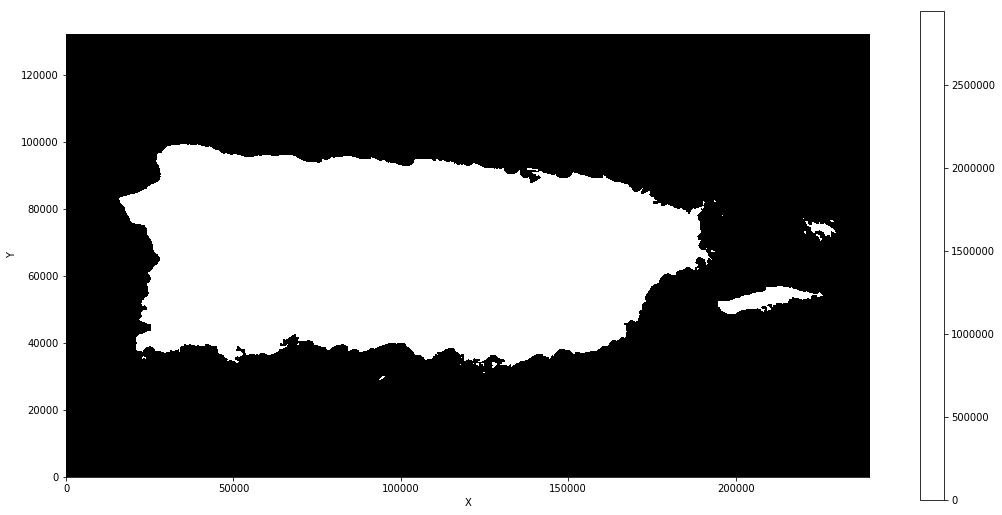

In [9]:
%%time
# somewhat slow step

fig, ax = plt.subplots(figsize=(18, 9))
landlab.plot.imshow_grid(grid, watersheds, cmap=rand_cmap(watersheds.max()))

## Read sample locations

In this next section, we read in location data from a CSV file, look to see where they are on the grid and then overlay them onto the DEM.

In [10]:
import pandas

In [26]:
#data = pandas.read_csv("data/sample_locations.txt")

data = pandas.read_csv('data/CommunityWaterTreatment_PointXY.csv')
CWT_1 = data.loc[data['POINT_X']!=0,:].reset_index(drop=True)
CWT_1

,FID,FRS_FACILI,REGISTRY_I,PRIMARY_NA,LOCATION_A,SUPPLEMENT,CITY_NAME,COUNTY_NAM,FIPS_CODE,STATE_CODE,...,LATITUDE83,LONGITUDE8,CONVEYOR,COLLECT_DE,ACCURACY_V,REF_POINT_,HDATUM_DES,SOURCE_DES,POINT_X,POINT_Y
0,3,http://ofmpub.epa.gov/enviro/fii_query_detail....,1.100525e+11,ASOCIACION ACUEDUCTO REVENTON - REVENTON,PR-388 KM 3.1 BO SALTILLO,SECTOR REVENTON,ADJUNTAS,ADJUNTAS,72001,PR,...,18.101397,-66.723872,REGION02,ADDRESS MATCHING-NEAREST INTERSECTION,1000,PLANT ENTRANCE (GENERAL),NAD83,,-66.723872,18.101397
1,6,http://ofmpub.epa.gov/enviro/fii_query_detail....,1.100189e+11,JOSE B. BARCELO VOCATIONAL SCHOOL,PR-518 KM 1.1 BO SALTILLO,,ADJUNTAS,ADJUNTAS,72001,PR,...,18.145441,-66.759136,REGION02,INTERPOLATION - DIGITAL MAP SRCE (TIGER),1000,,NAD83,,-66.759136,18.145441
2,10,http://ofmpub.epa.gov/enviro/fii_query_detail....,1.100107e+11,PRASA - GUILARTE WTP,PR-131 KM 2.5,,ADJUNTAS,ADJUNTAS,72001,PR,...,18.185338,-66.766951,FRS,ADDRESS MATCHING-HOUSE NUMBER,150,,NAD83,,-66.766951,18.185338
3,14,http://ofmpub.epa.gov/enviro/fii_query_detail....,1.100525e+11,TANAMA COMUNAL - TANAMA COMUNAL,PR-526 KM.6.4,BO.TANAMA,ADJUNTAS,ADJUNTAS,72001,PR,...,18.213482,-66.745824,REGION02,INTERPOLATION - DIGITAL MAP SRCE (TIGER),1000,,NAD83,,-66.745824,18.213482
4,36,http://ofmpub.epa.gov/enviro/fii_query_detail....,1.100502e+11,CUYON - BAUZA WELL NO. 1,CARR 1 KM 69.1,,AIBONITO,AIBONITO,,PR,...,18.141850,-66.261350,FRS-GEOCODE,ADDRESS MATCHING-BLOCK FACE,500,ENTRANCE POINT OF A FACILITY OR STATION,NAD83,,-66.261350,18.141850
5,37,http://ofmpub.epa.gov/enviro/fii_query_detail....,1.100243e+11,NATIVE CHEMICALS,PR-718 KM 0.9 BO PASTO SECTOR CARDIN,,AIBONITO,AIBONITO,72009,PR,...,18.119312,-66.270567,REGION02,INTERPOLATION - DIGITAL MAP SRCE (TIGER),1000,,NAD83,,-66.270567,18.119312
6,38,http://ofmpub.epa.gov/enviro/fii_query_detail....,1.100131e+11,PRASA ALGARROBO SYS,PR-717 KM 6.2,,AIBONITO,AIBONITO,72009,PR,...,18.103210,-66.275590,REGION02,ADDRESS MATCHING-NEAREST INTERSECTION,1000,PLANT ENTRANCE (GENERAL),NAD83,,-66.275590,18.103210
7,39,http://ofmpub.epa.gov/enviro/fii_query_detail....,1.100137e+11,ARECIBO URBANO (PRASA),PR-636 KM 1.3 INT,,ARECIBO,ARECIBO,72013,PR,...,18.411359,-66.713802,ICIS,INTERPOLATION-MAP,300,CENTER OF A FACILITY OR STATION,NAD83,,-66.713802,18.411359
8,40,http://ofmpub.epa.gov/enviro/fii_query_detail....,1.100523e+11,GLOBAL COMMODITY GROUP - UP JOHN COMPANY,CARR 2 KM 60.0,BO. SABANA HOYOS,ARECIBO,ARECIBO,72013,PR,...,18.469010,-66.747940,FRS-GEOCODE,ADDRESS MATCHING-BLOCK FACE,500,ENTRANCE POINT OF A FACILITY OR STATION,NAD83,,-66.747940,18.469010
9,41,http://ofmpub.epa.gov/enviro/fii_query_detail....,1.100132e+11,PRASA ESPERANZA,PR-635 KM 5.8 INT.,,ARECIBO,ARECIBO,72013,PR,...,18.387116,-66.748446,FRS,ADDRESS MATCHING-HOUSE NUMBER,150,,NAD83,,-66.748446,18.387116


Note that the location data are expressed as *lat*-*lon* but the grid node coordinates are in meters (you can double check this by looking at values in the *grid.x_of_node* and *grid.y_of_node* arrays).

To map the *lat*-*lon* locations, we can use the `pyproj` package.

In [12]:
#data

In [13]:
import pyproj

The following projection string is for Puerto Rico.

In [14]:
proj = pyproj.Proj('+proj=utm +zone=20N +ellps=WGS84')

In [15]:
help(grid.find_nearest_node)

Help on method find_nearest_node in module landlab.grid.raster:

find_nearest_node(coords, mode='raise') method of landlab.grid.raster.RasterModelGrid instance
    Node nearest a point.
    
    Find the index to the node nearest the given x, y coordinates.
    Coordinates are provided as numpy arrays in the *coords* tuple.
    
    Use the *mode* keyword to specify what to do if the given coordinates
    are out-of-bounds. See :func:`np.ravel_multi_index` for a
    description of possible values for *mode*. Note that a coordinate is
    out-of-bounds if it is beyond one half the node spacing from the
    exterior nodes.
    
    Returns the indices of the nodes nearest the given coordinates.
    
    Parameters
    ----------
    coords : tuple of array-like
        Coordinates of points.
    mode : {'raise', 'wrap', 'clip'}, optional
        What to do if a point is off the grid.
    
    Returns
    -------
    array-like
        IDs of the nearest nodes.
    
    Notes
    -----
  

In [27]:
CWT_1

,FID,FRS_FACILI,REGISTRY_I,PRIMARY_NA,LOCATION_A,SUPPLEMENT,CITY_NAME,COUNTY_NAM,FIPS_CODE,STATE_CODE,...,LATITUDE83,LONGITUDE8,CONVEYOR,COLLECT_DE,ACCURACY_V,REF_POINT_,HDATUM_DES,SOURCE_DES,POINT_X,POINT_Y
0,3,http://ofmpub.epa.gov/enviro/fii_query_detail....,1.100525e+11,ASOCIACION ACUEDUCTO REVENTON - REVENTON,PR-388 KM 3.1 BO SALTILLO,SECTOR REVENTON,ADJUNTAS,ADJUNTAS,72001,PR,...,18.101397,-66.723872,REGION02,ADDRESS MATCHING-NEAREST INTERSECTION,1000,PLANT ENTRANCE (GENERAL),NAD83,,-66.723872,18.101397
1,6,http://ofmpub.epa.gov/enviro/fii_query_detail....,1.100189e+11,JOSE B. BARCELO VOCATIONAL SCHOOL,PR-518 KM 1.1 BO SALTILLO,,ADJUNTAS,ADJUNTAS,72001,PR,...,18.145441,-66.759136,REGION02,INTERPOLATION - DIGITAL MAP SRCE (TIGER),1000,,NAD83,,-66.759136,18.145441
2,10,http://ofmpub.epa.gov/enviro/fii_query_detail....,1.100107e+11,PRASA - GUILARTE WTP,PR-131 KM 2.5,,ADJUNTAS,ADJUNTAS,72001,PR,...,18.185338,-66.766951,FRS,ADDRESS MATCHING-HOUSE NUMBER,150,,NAD83,,-66.766951,18.185338
3,14,http://ofmpub.epa.gov/enviro/fii_query_detail....,1.100525e+11,TANAMA COMUNAL - TANAMA COMUNAL,PR-526 KM.6.4,BO.TANAMA,ADJUNTAS,ADJUNTAS,72001,PR,...,18.213482,-66.745824,REGION02,INTERPOLATION - DIGITAL MAP SRCE (TIGER),1000,,NAD83,,-66.745824,18.213482
4,36,http://ofmpub.epa.gov/enviro/fii_query_detail....,1.100502e+11,CUYON - BAUZA WELL NO. 1,CARR 1 KM 69.1,,AIBONITO,AIBONITO,,PR,...,18.141850,-66.261350,FRS-GEOCODE,ADDRESS MATCHING-BLOCK FACE,500,ENTRANCE POINT OF A FACILITY OR STATION,NAD83,,-66.261350,18.141850
5,37,http://ofmpub.epa.gov/enviro/fii_query_detail....,1.100243e+11,NATIVE CHEMICALS,PR-718 KM 0.9 BO PASTO SECTOR CARDIN,,AIBONITO,AIBONITO,72009,PR,...,18.119312,-66.270567,REGION02,INTERPOLATION - DIGITAL MAP SRCE (TIGER),1000,,NAD83,,-66.270567,18.119312
6,38,http://ofmpub.epa.gov/enviro/fii_query_detail....,1.100131e+11,PRASA ALGARROBO SYS,PR-717 KM 6.2,,AIBONITO,AIBONITO,72009,PR,...,18.103210,-66.275590,REGION02,ADDRESS MATCHING-NEAREST INTERSECTION,1000,PLANT ENTRANCE (GENERAL),NAD83,,-66.275590,18.103210
7,39,http://ofmpub.epa.gov/enviro/fii_query_detail....,1.100137e+11,ARECIBO URBANO (PRASA),PR-636 KM 1.3 INT,,ARECIBO,ARECIBO,72013,PR,...,18.411359,-66.713802,ICIS,INTERPOLATION-MAP,300,CENTER OF A FACILITY OR STATION,NAD83,,-66.713802,18.411359
8,40,http://ofmpub.epa.gov/enviro/fii_query_detail....,1.100523e+11,GLOBAL COMMODITY GROUP - UP JOHN COMPANY,CARR 2 KM 60.0,BO. SABANA HOYOS,ARECIBO,ARECIBO,72013,PR,...,18.469010,-66.747940,FRS-GEOCODE,ADDRESS MATCHING-BLOCK FACE,500,ENTRANCE POINT OF A FACILITY OR STATION,NAD83,,-66.747940,18.469010
9,41,http://ofmpub.epa.gov/enviro/fii_query_detail....,1.100132e+11,PRASA ESPERANZA,PR-635 KM 5.8 INT.,,ARECIBO,ARECIBO,72013,PR,...,18.387116,-66.748446,FRS,ADDRESS MATCHING-HOUSE NUMBER,150,,NAD83,,-66.748446,18.387116


Get the *x-y* locations from *lat-lon* and find the IDs of the nodes that are closest to these locations.

In [28]:
xy_of_location = proj(CWT_1["LONGITUDE8"].values, CWT_1["LATITUDE83"].values)
id_of_location = grid.find_nearest_node(proj(CWT_1["LONGITUDE8"].values, CWT_1["LATITUDE83"].values))

# xy_of_location = proj(CWT_1["POINT_X"].values, CWT_1["POINT_Y"].values)
# id_of_location = grid.find_nearest_node(xy_of_location[1][0], xy_of_location[0][0])

With the node IDs we can look at the elevations at those locations.

In [29]:
grid.at_node["topographic__elevation"][id_of_location]

array([ 879.1953  ,  833.4205  ,  554.8022  ,  743.8149  ,  600.459   ,
        622.6918  ,  462.9366  ,   58.15981 ,   56.61513 ,  213.3587  ,
        125.3457  ,  316.6161  ,  648.3862  ,  386.805   ,  286.2709  ,
        565.2126  ,  496.6614  ,  535.3193  ,  197.1592  ,  464.2298  ,
        394.0724  ,  145.7709  ,  671.8997  ,  346.6993  ,  209.8103  ,
         60.89298 ,  826.9106  ,  783.4286  ,  876.5096  ,  412.5532  ,
        663.8339  ,  695.9451  ,   99.08438 ,  776.3512  ,    7.169885,
        784.0076  ,  802.0392  ,  250.6194  ,  327.9012  ,  122.0237  ,
         88.55994 ,  223.7777  ,  471.0836  ,  349.1483  ,  169.2419  ,
        671.8031  ,  671.8031  ,  671.8031  ,   13.34476 ,   15.96704 ,
        570.044   ,   75.70026 ])

Or we can see the IDs of the watersheds that they are contained in.

In [30]:
watersheds[id_of_location]

array([     -1, 1712988, 1851654, 1950349, 1670895,      -1, 1529527,
       2590490, 2763800, 2505101, 1780503, 2263439, 1623097, 1676120,
       1604129, 2038987, 2073534, 2086851, 2276214, 1939880, 1913179,
       1879323, 1880823, 2056856, 1982138, 2633438, 1798144, 1921340,
       1793310, 1988038, 1966671, 1494327, 1448988,      -1, 1217086,
       1686492, 1689077,      -1, 1646006, 2312810, 2380369, 2065066,
       2126542, 2334510, 1606607, 1724006, 1724006, 1724006, 1356640,
       1364629, 1579457, 1408838])

Again plot the watersheds but this time just color the watersheds that contain the given locations.

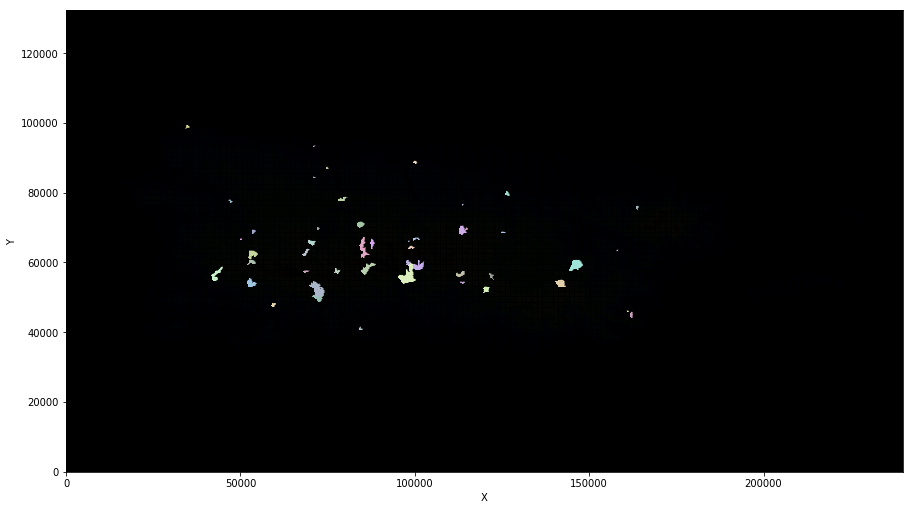

In [34]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,15))

landlab.plot.imshow_grid(grid, "topographic__elevation", cmap="terrain", allow_colorbar=False)
landlab.plot.imshow_grid(grid, watersheds, cmap=rand_cmap(watersheds.max(), select=watersheds[id_of_location]),
    allow_colorbar=False)

#plt.gca().set_xlim([190000, 230000])
#plt.gca().set_ylim([100000, 150000])

Add the watershed IDs to a new location data file.

In [19]:
data["Watershed ID"] = watersheds[id_of_location]
data.to_csv("data/locations_with_ids.csv", index=False)